# Finding Conserved Patterns Across Two Time Series

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/TDAmeritrade/stumpy/main?filepath=notebooks/Tutorial_AB_Joins.ipynb)

## AB-Joins

This tutorial is adapted from the [Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf) paper and replicates Figures 9 and 10.

Previously, we had introduced a concept called [time series motifs](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), which are conserved patterns found within a single time series, $T$, that can be discovered by computing its [matrix profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html) using STUMPY. This process of computing a matrix profile with one time series is commonly known as a "self-join" since the subsequences within time series $T$ are only being compared with itself. However, what do you do if you have two time series, $T_{A}$ and $T_{B}$, and you want to know if there are any subsequences in $T_{A}$ that can also be found in $T_{B}$? By extension, a motif discovery process involving two time series is often referred to as an "AB-join" since all of the subsequences within time series $T_{A}$ are compared to all of the subsequences in $T_{B}$. 

It turns out that "self-joins" can be trivially generalized to "AB-joins" and the resulting matrix profile, which annotates every subsequence in $T_{A}$ with its nearest subsequence neighbor in $T_{B}$, can be used to identify similar (or unique) subsequences across any two time series. Additionally, as long as $T_{A}$ and $T_{B}$ both have lengths that are greater than or equal to the subsequence length, $m$, there is no requirement that the two time series must be the same length. 

In this short tutorial we will demonstrate how to find a conserved pattern across two independent time series using STUMPY.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [1]:
%matplotlib inline

import stumpy
import pandas as pd
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

plt.style.use('stumpy.mplstyle')

## Finding Similarities in Music Using STUMPY

In this tutorial we are going to analyze two songs, “Under Pressure” by Queen and David Bowie as well as “Ice Ice Baby” by Vanilla Ice. For those who are unfamiliar, in 1990, Vanilla Ice was alleged to have sampled the bass line from "Under Pressure" without crediting the original creators and the copyright claim was later settled out of court. Have a look at this short video and see if you can hear the similarities between the two songs:

In [2]:
IFrame(width="560", height="315", src="https://www.youtube.com/embed/HAA__AW3I1M")

The two songs certainly share some similarities! But, before we move forward, imagine if you were the judge presiding over this court case. What analysis result would you need to see in order to be convinced, beyond a shadow of a doubt, that there was wrongdoing?

## Loading the Music Data

To make things easier, instead of using the raw music audio from each song, we're only going to use audio that has been pre-converted to a single frequency channel (i.e., the 2nd MFCC channel sampled at 100Hz).

In [3]:
queen_df = pd.read_csv("https://zenodo.org/record/4294912/files/queen.csv?download=1")
vanilla_ice_df = pd.read_csv("https://zenodo.org/record/4294912/files/vanilla_ice.csv?download=1")

print("Length of Queen dataset : " , queen_df.size)
print("Length of Vanilla ice dataset : " , vanilla_ice_df.size)

Length of Queen dataset :  24289
Length of Vanilla ice dataset :  23095


## Visualizing the Audio Frequencies

It was very clear in the earlier video that there are strong similarities between the two songs. However, even with this prior knowledge, it's incredibly difficult to spot the similarities (below) due to the sheer volume of the data: 

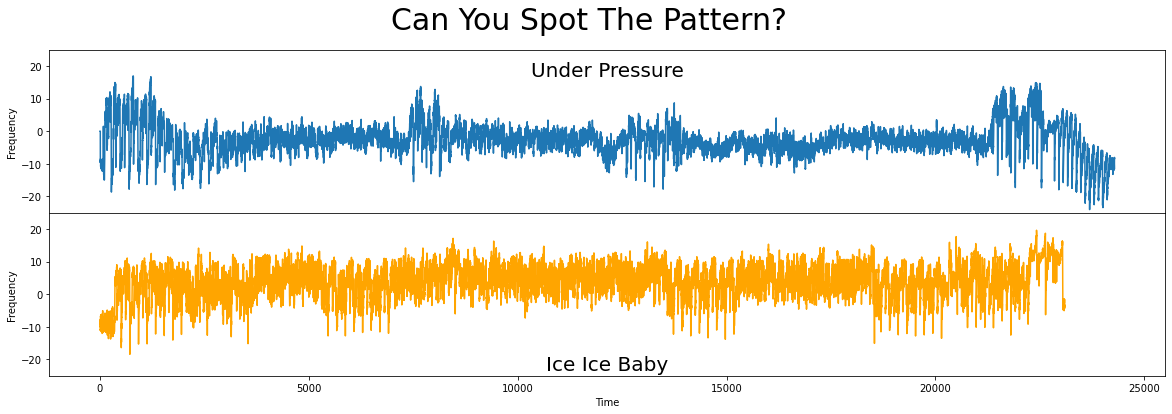

In [4]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Can You Spot The Pattern?', fontsize='30')

axs[0].set_title('Under Pressure', fontsize=20, y=0.8)
axs[1].set_title('Ice Ice Baby',  fontsize=20, y=0)

axs[1].set_xlabel('Time')

axs[0].set_ylabel('Frequency')
axs[1].set_ylabel('Frequency')

ylim_lower = -25
ylim_upper = 25
axs[0].set_ylim(ylim_lower, ylim_upper)
axs[1].set_ylim(ylim_lower, ylim_upper)

axs[0].plot(queen_df['under_pressure'])
axs[1].plot(vanilla_ice_df['ice_ice_baby'], c='orange')

plt.show()

## Performing an AB-Join with STUMPY

Fortunately, using the `stumpy.stump` function, we can quickly compute the matrix profile by performing an AB-join and this will help us easily identify and locate the similar subsequence(s) between these two songs:

In [5]:
m = 500
queen_mp = stumpy.stump(T_A = queen_df['under_pressure'], 
                        m = m,
                        T_B = vanilla_ice_df['ice_ice_baby'],
                        ignore_trivial = False)

Above, we call `stumpy.stump` by specifying our two time series `T_A = queen_df['under_pressure']` and `T_B = vanilla_ice_df['ice_ice_baby']`. Following the original published work, we use a subsequence window length of `m = 500` and, since this is not a self-join, we set `ignore_trivial = False`. The resulting matrix profile, `queen_mp`, essentially serves as an annotation for `T_A` so, for every subsequence in `T_A`, we find its closest subsequence in `T_B`. 

As a brief reminder of the matrix profile data structure, each row of `queen_mp` corresponds to each subsequence within `T_A`, the first column in `queen_mp` records the matrix profile value for each subsequence in `T_A` (i.e., the distance to its nearest neighbor in `T_B`), and the second column in `queen_mp` keeps track of the index location of the nearest neighbor subsequence in `T_B`.   

One additional side note is that AB-joins are not symmetrical in general. That is, unlike a self-join, the order of the input time series matter. So, an AB-join will produce a different matrix profile than a BA-join (i.e., for every subsequence in `T_B`, we find its closest subsequence in `T_A`).

## Visualizing the Matrix Profile

Just as we've done [in the past](https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html), we can now look at the matrix profile, `queen_mp`, computed from our AB-join:

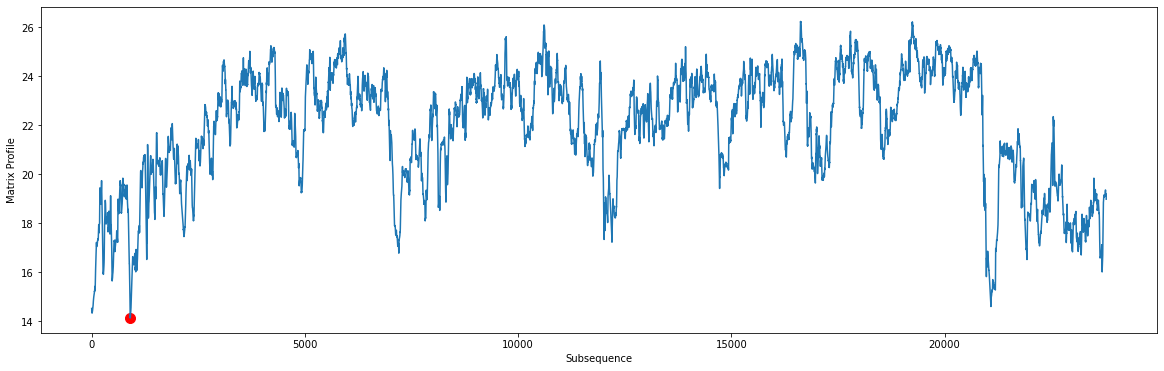

In [6]:
queen_motif_index = queen_mp[:, 0].argmin()

plt.xlabel('Subsequence')
plt.ylabel('Matrix Profile')

plt.scatter(queen_motif_index, 
               queen_mp[queen_motif_index, 0],
               c='red',
               s=100)

plt.plot(queen_mp[:,0])

plt.show()

Now, to discover the global motif (i.e., the most conserved pattern), `queen_motif_index`, all we need to do is identify the index location of the lowest distance value in the `queen_mp` matrix profile (see red circle above).

In [7]:
queen_motif_index = queen_mp[:, 0].argmin()
print(f'The motif is located at index {queen_motif_index} of "Under Pressure"')

The motif is located at index 904 of "Under Pressure"


In fact, the index location of its nearest neighbor in "Ice Ice Baby" is stored in `queen_mp[queen_motif_index, 1]`:

In [8]:
vanilla_ice_motif_index = queen_mp[queen_motif_index, 1]
print(f'The motif is located at index {vanilla_ice_motif_index} of "Ice Ice Baby"')

The motif is located at index 288 of "Ice Ice Baby"


## Overlaying The Best Matching Motif

After identifying the motif and retrieving the index location from each song, let's overlay both of these subsequences and see how similar they are to each other: 

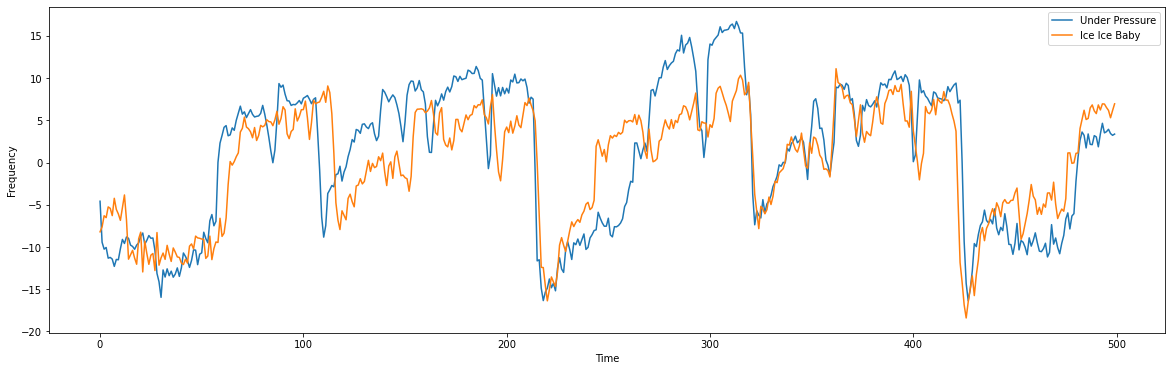

In [9]:
plt.plot(queen_df.iloc[queen_motif_index : queen_motif_index + m].values, label='Under Pressure')
plt.plot(vanilla_ice_df.iloc[vanilla_ice_motif_index:vanilla_ice_motif_index+m].values, label='Ice Ice Baby')

plt.xlabel('Time')
plt.ylabel('Frequency')

plt.legend()

plt.show()

Wow, the resulting overlay shows really strong correlation between the two subsequences! Are you convinced?

## Summary

And that's it! In just a few lines of code, you learned how to compute a matrix profile for two time series using STUMPY and identified the top-most conserved behavior between them. While this tutorial has focused on audio data, there are many further applications such as detecting imminent mechanical issues in sensor data by comparing to known experimental or historical failure datasets or finding matching movements in commodities or stock prices, just to name a few.

You can now import this package and use it in your own projects. Happy coding!

## Resources

[Matrix Profile I](https://www.cs.ucr.edu/~eamonn/PID4481997_extend_Matrix%20Profile_I.pdf)

[STUMPY Documentation](https://stumpy.readthedocs.io/en/latest/)

[STUMPY Matrix Profile Github Code Repository](https://github.com/TDAmeritrade/stumpy)